# Hyperparameter Search for FasterRCNN and Visualizing Predictions

In this notebook, I'll demonstrate the [Weights and Biases library](https://docs.wandb.com/)'s automated hyperparameter optimization functionality on FasterRCNN. We'll use it to measure our model's performance quickly, find optimal hyperparameters, monitor system stats like GPU utilization and log the bounding boxes predicted by our FasterRCNN models.

## [Explore results in a live dashboard →](https://app.wandb.ai/kshen/GWD-fasterRCNN?workspace=user-lavanyashukla)
![](https://i.imgur.com/Jt8EKf0.png)

Only a small subset of the data will be used to demonstrate training and validation to avoid GPU out of memory error due to Kaggle's memory limit. This is only to demonstrate how to integrate W&B and the code can be modified to suit your purpose or run on a local machine.

In this example, we are trying to find the best combination of epochs, batch size, and learning rate to minimize the training loss. You can set what metric to optimize for, we will just use training loss as an example. Other metrics/scores such as the Average Precision Score will also be logged for the validation set (technically the Mean Average Precision Score if evaluated on entire set, see [this kernel](https://www.kaggle.com/pestipeti/competition-metric-details-script)).

### If you like this kernel please give it an upvote :)

- [Docs for W&B hyperparameter sweeps](https://docs.wandb.com/sweeps)

- [W&B for Kaggle](https://www.wandb.com/kaggle)

- Original FasterRCNN notebooks (@pestipeti):

    - [Kernel 1](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)

    - [Kernel 2](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

# Setup

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import gc

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [ ]:
#Install + import Weights and Biases
!pip install --upgrade wandb
import wandb

In [ ]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape
train_df.head()

In [ ]:
#Extract the bbox column and explode it into x,y,w,h
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

### Select a small subset for demo purposes.

In [ ]:
image_ids = train_df['image_id'].unique()
#Original: 3373 total images divided into 2708 for training, 665 for validation
#valid_ids = image_ids[-665:]
#train_ids = image_ids[:-665]

#Select smaller set: 677 for training, 166 for validation (1/4 size original) to avoid any CUDA out of memory issues
train_ids = image_ids[:677]
valid_ids = image_ids[677:677+166]

In [ ]:
print(image_ids.shape)
print(valid_ids.shape)
print(train_ids.shape)

In [ ]:
#take the bounding boxes and put them into their respective category (train, valid) by id 
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [ ]:
valid_df.shape, train_df.shape

In [ ]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique() #all images
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        #load image and normalize image pixels to 0-1
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x', 'y', 'w', 'h']].values
        #turn each bounding box into format [x_start, y_start, x_end, y_end]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        #calculate areas of each bounding box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels #all boxes are labelled as 1 (wheat head)
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        #apply transformations to this image
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# Albumentations (pretty much image data augmentation)
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

#Collate function
def collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
#IOU Metric Calculation
from collections import namedtuple
from typing import List, Union

Box = namedtuple('Box', 'xmin ymin xmax ymax')


def calculate_iou(gt: List[Union[int, float]],
                  pred: List[Union[int, float]],
                  form: str = 'pascal_voc') -> float:
    """Calculates the IoU.
    
    Args:
        gt: List[Union[int, float]] coordinates of the ground-truth box
        pred: List[Union[int, float]] coordinates of the prdected box
        form: str gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        IoU: float Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        bgt = Box(gt[0], gt[1], gt[0] + gt[2], gt[1] + gt[3])
        bpr = Box(pred[0], pred[1], pred[0] + pred[2], pred[1] + pred[3])
    else:
        bgt = Box(gt[0], gt[1], gt[2], gt[3])
        bpr = Box(pred[0], pred[1], pred[2], pred[3])
        

    overlap_area = 0.0
    union_area = 0.0

    # Calculate overlap area
    dx = min(bgt.xmax, bpr.xmax) - max(bgt.xmin, bpr.xmin)
    dy = min(bgt.ymax, bpr.ymax) - max(bgt.ymin, bpr.ymin)

    if (dx > 0) and (dy > 0):
        overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (bgt.xmax - bgt.xmin) * (bgt.ymax - bgt.ymin) +
            (bpr.xmax - bpr.xmin) * (bpr.ymax - bpr.ymin) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
#MAP Calculation
def find_best_match(gts, predd, threshold=0.5, form='pascal_voc'):
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).
    
    Args:
        gts: Coordinates of the available ground-truth boxes
        pred: Coordinates of the predicted box
        threshold: Threshold
        form: Format of the coordinates
        
    Return:
        Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    
    for gt_idx, ggt in enumerate(gts):
        iou = calculate_iou(ggt, predd, form=form)
        
        if iou < threshold:
            continue
        
        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx


def calculate_precision(preds_sorted, gt_boxes, threshold=0.5, form='coco'):
    """Calculates precision per at one threshold.
    
    Args:
        preds_sorted: 
    """
    tp = 0
    fp = 0
    fn = 0

    fn_boxes = []

    for pred_idx, pred in enumerate(preds_sorted):
        best_match_gt_idx = find_best_match(gt_boxes, pred, threshold=threshold, form=form)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1

            # Remove the matched GT box
            gt_boxes = np.delete(gt_boxes, best_match_gt_idx, axis=0)

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fn += 1
            fn_boxes.append(pred)

    # False negative: indicates a gt box had no associated predicted box.
    fp = len(gt_boxes)
    precision = tp / (tp + fp + fn)
    return precision, fn_boxes, gt_boxes


def calculate_image_precision(preds_sorted, gt_boxes, thresholds=(0.5), form='coco', debug=False):
    
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    for threshold in thresholds:
        precision_at_threshold, _, _ = calculate_precision(preds_sorted,
                                                           gt_boxes,
                                                           threshold=threshold,
                                                           form=form
                                                          )
        if debug:
            print("@{0:.2f} = {1:.4f}".format(threshold, precision_at_threshold))

        image_precision += precision_at_threshold / n_threshold
    
    return image_precision

# Logging metrics and predicted bounding boxes
Here we define train and test functions that will use the W&B logging features as well as setting up the hyperparameter sweep configuration.

In [ ]:


def train(args, model, device, train_data_loader, optimizer, epoch, iteration):
    print("Epoch: ", epoch)
    
    #Train Loop
    for batch_idx, (images, targets, image_ids) in enumerate(train_data_loader):
        
        #Train and calculate loss
        model.train()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            #Log the train loss and iteration
            wandb.log({"train_loss": loss_value, "iteration_train": iteration})
        
        iteration += 1 #iteration increases for every batch
        
    
    return iteration #returns the updated new iteration
            

In the test function we will also log the bounding boxes so we can see visualizations.

In [ ]:
#[xmin, ymin, xmax, ymax] => [x, y, width, height]
def convert_boxes_format(boxes):
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    return boxes

class_id_to_label = {
    0: "target",
    1: "wheat"
}

#Test will run as validation and log bounding boxes with confidence/prediction scores
def test(args, model, device, test_data_loader, epoch, iteration):
    model.eval()
    
    epoch_precision_score = []
    for batch_idx, (images, targets, image_ids) in enumerate(test_data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        
        #Calculate Precision Score Per Batch
        batch_precision_score = 0
        for i, image in enumerate(images):
            
            #predicted bounding boxes
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            boxes = convert_boxes_format(boxes)
            
            scores = outputs[i]['scores'].data.cpu().numpy()
            
            #ground truth bounding boxes
            gt_boxes = targets[i]["boxes"].cpu().numpy()
            gt_boxes = convert_boxes_format(gt_boxes)

            image_id = image_ids[i]

            # Sort highest confidence -> lowest confidence
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = boxes[preds_sorted_idx]

            iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
            image_precision = calculate_image_precision(preds_sorted, gt_boxes,
                                            thresholds=iou_thresholds,
                                            form='coco', debug=True)
            
            print("Average Precision of image: {0:.4f}".format(image_precision))
            batch_precision_score +=  image_precision
        
        batch_precision_score = batch_precision_score / len(images) #average precision score for the batch
        epoch_precision_score.append(batch_precision_score)
        
        if batch_idx % args.log_interval == 0:
            #logs the precision score per batch and also the iteration
            wandb.log({"batch_score_validation": batch_precision_score, "iteration_validation": iteration})
        
        #Log bounding boxes
        if batch_idx % args.image_log_interval == 0:
            
            #Log 1 image with bounding boxes for this batch
            for i, image in enumerate(images[:1]): 

                image_id = image_ids[i]
                scores = outputs[i]['scores'].data.cpu().numpy().astype(np.float64)

                #predicted bounding boxes
                boxes = outputs[i]['boxes'].data.cpu().numpy().astype(np.float64)
                predicted_boxes = []
                for b_i, box in enumerate(boxes):
    
                    box_data = {"position" : {
                          "minX" : box[0],
                          "maxX" : box[2],
                          "minY" : box[1],
                          "maxY" : box[3] 
                        },
                      "class_id" : 1,
                      "box_caption" : "wheat: (%.3f)" % (scores[b_i]),
                      "domain": "pixel",
                      "scores" : { "score" : scores[b_i] }
                    }
                    predicted_boxes.append(box_data)
                    

                #ground truth bounding boxes
                gt_boxes = targets[i]["boxes"].cpu().numpy().astype(np.float64)
                target_boxes = [] 
                for b_i, box in enumerate(gt_boxes):
  
                    box_data = {"position" : {
                          "minX" : box[0],
                          "maxX" : box[2],
                          "minY" : box[1],
                          "maxY" : box[3] 
                        },
                      "class_id" : 0,
                      "domain": "pixel",
                      "box_caption" : "ground_truth"
                    }
                    target_boxes.append(box_data)
                
                
                image = image.permute(1,2,0).cpu().numpy().astype(np.float64)
                
                #create image object and log
                img = wandb.Image(image, boxes = 
                                  {"predictions": 
                                   {"box_data": predicted_boxes, 
                                    "class_labels" : class_id_to_label},"ground_truth": {"box_data": target_boxes}})
                
                wandb.log({"bounding_boxes": img})
            
        iteration += 1
    
    epoch_precision_score = sum(epoch_precision_score) / len(epoch_precision_score) 
    wandb.log({"epoch_score_validation": batch_precision_score, "epoch": epoch})
    return iteration
        
    

In [ ]:
#Load dataset
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

# Define Sweep Configuration and Run
A sweep configuration defines all the values that W&B will try and the metric that it will be using to judge which set of values do the best.


In [ ]:
#Hyperparameter sweep configuration (more info the the W&B docs)
sweep_config = {
    'method': 'grid', #grid, random (random will continue running until you terminate it or specify a target field for metric)
    'metric': {
      'name': 'train_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [2, 4]
        },
        'batch_size': {
            'values': [4, 8]
        },
        'lr': {
            'values': [1e-3, 5e-4] 
        }
    }
}

#initialize the sweep
#Running this line will ask you to log into your W&B account
sweep_id = wandb.sweep(sweep_config, project="GWD-fasterRCNN")

The run function is the main function.

Note that we are keeping track of the iterations separately for train and test. 

This will allow for easier plotting of values in your W&B dashboard.

You can set the X axis for charts to use iteration_train for displaying training loss/accuracy, or iteration_test for displaying values such as validation/test loss/accuracy.

The wandb.watch() function only needs to be called once, so in subsequent runs we can comment it out.

In [ ]:
def run():
    
    #Default Hyperparameter values if no sweep is defined
    config_default = {         
    "batch_size": 8,          # input batch size for training (default: 64)
    "test_batch_size": 8,    # input batch size for testing (default: 1000)
    "epochs": 2,             # number of epochs to train (default: 10)
    "lr": 0.005,               # learning rate (default: 0.01)
    "momentum": 0.9,          # SGD momentum (default: 0.5) 
    "no_cuda": False,         # whether to disable CUDA training
    "seed": 42,               # random seed (default: 42)
    "log_interval": 1,      #how many batches to wait before logging in train/test loops
    "image_log_interval": 10,
    "decay": 0.0005
    }
    wandb.init(config=config_default, project="GWD-fasterRCNN")
    config = wandb.config
    
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2  # wheat (1)....or not wheat (0)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    use_cuda = not config["no_cuda"] and torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config["seed"]) # pytorch random seed
    np.random.seed(config["seed"]) # numpy random seed
    torch.backends.cudnn.deterministic = True


    #Create dataloaders
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=config["test_batch_size"],
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )


    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=config["lr"], momentum=config["momentum"], weight_decay=config["decay"])
    
    ####
    wandb.watch(model, log="all") #this line only needs to be run once to hook W&B to your model (comment out for future runs)
    ####
    
    #Keep track of train and test's iterations seperatedly (this allows for easier plotting because you can use iteration_train or iteration_test for your X axis)
    iteration_train = 0
    iteration_test = 0
    for epoch in range(1, config["epochs"] + 1):
        #Runs training and returns the new training iteration counter
        iteration_train = train(config, model, device, train_data_loader, optimizer, epoch, iteration_train)
        #Runs testing/valiadtion and returns the new test iteration counter
        iteration_test = test(config, model, device, valid_data_loader, epoch, iteration_test)
        print("Iteration Train: ", iteration_train)
        print("Iteration Test: ", iteration_test)

    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
    wandb.save('fasterrcnn_resnet50_fpn.pth')
    
    #Clear memory
    del model
    del train_data_loader
    del valid_data_loader
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
#Run sweep
wandb.agent(sweep_id, run)
print("FINISHED")

### Hyperparameter sweep results
The HP sweep will produce 2x2x2=8 runs (because in the sweep config, there are 2 values being tested for each of epochs,batch size,and lr)

https://app.wandb.ai/kshen/GWD-fasterRCNN/sweeps/uuo3vref


Weights and Biases provides visualizations to compare different HP configurations. Each run can be plotted on a parallel chart. 

Here we can see that the run highlighted in purple has a hyperparameter config that results in the smallest train loss.

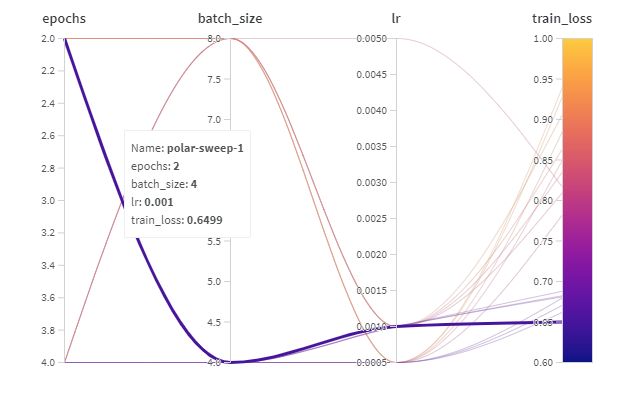



By metrics batch_score_validation or train_loss we can see that certain runs/configurations can produce better scores:

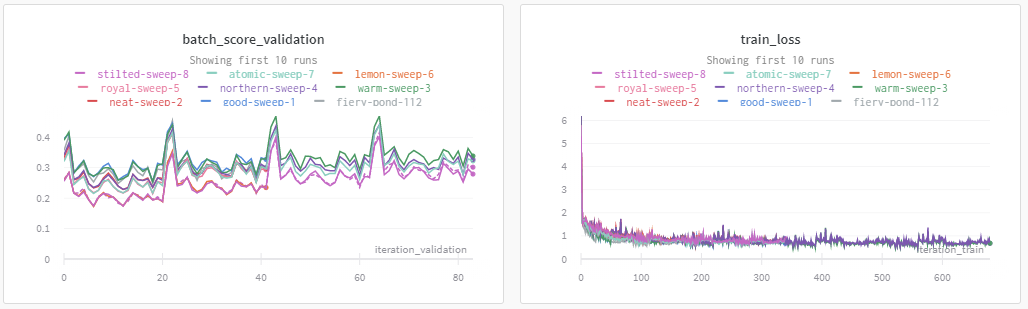

### Bounding Boxes

We can also see the bounding boxes that we logged for our runs (a sample image from a run is shown below). Visualizing bounding boxes can help you see what your model is getting right and wrong by visualizing the ground truth boxes compared with our predictions. 

In the sample below, we can see that one major source of error is that leaves can be detected as wheat heads. However, as mentioned at the beginning, since this is only trained on a small subset for demo purposes, the conclusions made here shouldn't be taken at face value.

![](https://i.imgur.com/yP2sF1k.png)